In [527]:
%load_ext autoreload
%autoreload 2
import os
import glob
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
pd.options.display.max_columns = 999
import sys
sys.path.append("../../Code")
import vader
import settings as s
import utils 
import seaborn as sns 
import afinns as af
import s140
import opinion_lexicon as op
import so_cal as sc
import sentiment as sent
import analysis
import languages as lang

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [2229]:
import textblob as tb

In [2235]:
details = tb.TextBlob('My first experience with Airbnb in this apartment in Manhattan turned out to be a nightmare. As the host had told us, he or she (we never got to know their gender) would not be at the apt when we arrived. Instead, we were given the keys and some info on the location of the room and the shared bathroom, by a friend of the host. Although the apt was not as shown in the pictures, but a little dirtier and with the walls really bad painted, we did not care. ')

In [2236]:
details.sentiment

Sentiment(polarity=0.11250000000000002, subjectivity=0.7)

In [2222]:
reviews = pd.read_csv('reviews_with_sent.csv', index_col=0)

In [1679]:
reviews = reviews[~reviews['so_cal'].isnull()]

In [1759]:
reviews = reviews.rename(columns={c:c.replace("-", "_") for c in reviews.columns})

In [2234]:
reviews[reviews['afinn'] <-10].head(3)

,idGuestReview,id,date,reviewer_id,listing_id,recipient_id,comments,hostCancelled,token_len,num_of_sents,google_langs,google_langs_conf,langdetect_langs,langdetect_langs_conf,other_langs,translated,afinn,vader,s140,so_cal,opinion_bow,opinion_freq,afinn-sent,vader-sent,opinion_bow-sent,opinion_freq-sent,s140-sent,so_cal-sent
538,776,12649702,2014-05-07,9736455,5178,8967,"My first experience with Airbnb in this apartment in Manhattan turned out to be a nightmare. As the host had told us, he or she (we never got to know their gender) would not be at the apt when we arrived. Instead, we were given the keys and some info on the location of the room and the shared bathroom, by a friend of the host. Although the apt was not as shown in the pictures, but a little dirtier and with the walls really bad painted, we did not care. The building is very old and the rugs l...",N,330,15,en,1.0,en,0.999996,0,NaN,-12.0,-0.9733,0,-2.183333,-0.068376,-0.036364,"[0.0, 0.0, 2.0, -3.0, -3.0, -2.0, 0.0, 0.0, 0.0, -1.0, -6.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.6808, -0.906, -0.5472, 0.0, 0.0, 0.4588, 0.0, 0.0772, -0.8625, 0.0, 0.0, 0.4404, 0.0]","[-0.14285714285714285, 0.0, 0.0, -0.09090909090909091, -0.07692307692307693, -0.4, -0.058823529411764705, 0.0, 0.0, -0.2, -0.36363636363636365, -0.13333333333333333, 0.0, 0.5, 0.2]","[-0.0625, 0.0, 0.0, -0.04, -0.03333333333333333, -0.25, -0.022727272727272728, 0.0, 0.0, -0.08695652173913043, -0.17391304347826086, -0.05128205128205128, 0.0, 0.2, 0.14285714285714285]","[2, 0, 2, 0, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2]","[-4.5, 2.0, 2.0, -3.95, -5.1000000000000005, -3.75, -3.0, -0.25, 0.0, -3.0, -3.0, -1.5, 0.0, 1.0, 0.0]"
14289,29108,11537537,2014-04-07,3380780,66718,136227,"The apartment is located in a ragged building and it, itself, presents a deterioration that does not appear at all in the advertisement: dirties floors and windows, worn-out bed linen, poor mattress, bad frying pans, etc.. Nevertheless the main problem of it is the hot: the kitchen, restroom and a room do not have heating but a pipe goes through the wall from top to bottom to the upper stores making sometimes the heat unbearable which only can be remedied opening the windows even at midnigh...",N,163,4,en,1.0,en,0.999997,0,NaN,-12.0,-0.9287,0,-2.115385,-0.079365,-0.024540,"[-6.0, -2.0, -6.0, 2.0]","[-0.765, 0.09, -0.7684, -0.1695]","[-0.25, 0.0, -0.04999999999999999, 0.25]","[-0.13513513513513514, 0.0, -0.018518518518518517, 0.09090909090909091]","[0, 0, 0, 2]","[-3.375, -1.75, -1.6666666666666667, -0.75]"
17329,35408,12432574,2014-05-02,12451742,100002,523218,"Gregorio is a nice person, but we did need some intervention with airbnb. I stayed at his place for the month of April, until my apartment was ready for a May move-in date. The first week was a bit challenging. It seems the drains have been neglected for a while, and neither the bathroom sink or the tubs drained properly. Also, the building is an older building, so certain plumbing fixtures are retrofitted. One issue is the claw bathtub having a retrofitted shower. The main shower head is ov...",N,502,32,en,1.0,en,0.999995,0,NaN,-11.0,-0.9559,0,-0.924390,-0.033708,-0.017928,"[3.0, 0.0, 0.0, -4.0, 1.0, 0.0, 0.0, 2.0, 1.0, 1.0, 0.0, -1.0, 3.0, -2.0, -2.0, -3.0, -3.0, 0.0, -5.0, -1.0, 3.0, -2.0, -2.0, -1.0, -2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0]","[0.2263, 0.3612, 0.1531, -0.7096, 0.4101, 0.0, 0.0, 0.4939, -0.1139, -0.0191, 0.0, -0.296, -0.092, 0.0, -0.2732, 0.0516, -0.5346, 0.0, -0.6808, 0.2732, -0.4585, -0.4019, -0.4019, -0.1531, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2846, -0.4201]","[0.16666666666666666, 0.1111111111111111, -0.25, -0.3333333333333333, 0.0, -0.16666666666666666, 0.0, 0.14285714285714285, 0.0, 0.0, -0.25, 0.0, 0.09090909090909091, -0.3333333333333333, 0.0, -0.08333333333333333, -0.08333333333333333, 0.0, -0.08333333333333333, -0.1111111111111111, 1.0, 0.0, -0.09090909090909091, -0.14285714285714285, -0.3333333333333333, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, -0.16666666666666666]","[0.

In [1681]:
len(reviews)

225090

In [1456]:
def voter_counts(src_tbl, voters):
    counts = {'total': len(src_tbl)}
    for voter in voters:
        counts[voter] = len(src_tbl[src_tbl[voter] == src_tbl['vote']])
    return pd.DataFrame(counts,index=[0])

In [1739]:
def join_multi_table(tbls, chosen):
    result = tbls[0][['id', 'comments', chosen[0]]]
    for i, t in zip(range(1, len(tbls)), tbls[1:]):
        result = result.join(t[['id', chosen[i]]].set_index('id'), on='id')
    return result

In [1453]:
from scipy import stats
def majority_vote(src_tbl, voters):
    src_tbl['vote'] = np.array(stats.mode(src_tbl[voters], axis=1))[0].flatten()
    return src_tbl

In [1682]:
def normalise_tools(tbl, tools):
    tbl.is_copy = False
    for t in tools:
        tbl[t] = utils.minmaxscale(tbl[t])
    return tbl

In [1773]:
def normalise_tools_sent(tbl, tools):
    tbl.is_copy = False
    for t in tools:
        tbl[t] = utils.minmaxscale_sent(tbl, t, True)
    return tbl

In [1853]:
def plot_distributions(tbl, tools):
    for t in tools:
        sns.distplot(tbl[t].astype(float))
        plt.show()

# Whole reviews

In [1721]:
main_tools = ['afinn', 'vader', 's140', 'so_cal', 'opinion_bow']

In [1722]:
reviews[main_tools].describe()

,afinn,vader,s140,so_cal,opinion_bow
count,225090.000000,225090.000000,225090.000000,225090.000000,225090.000000
mean,11.925648,0.867730,3.273526,2.608295,0.217078
std,7.802188,0.226526,1.164743,1.540444,0.122875
min,-35.000000,-0.996400,0.000000,-15.000000,-1.000000
25%,7.000000,0.865000,2.000000,1.800936,0.136364
50%,11.000000,0.940200,4.000000,2.500000,0.200000
75%,16.000000,0.971900,4.000000,3.280000,0.285714
max,116.000000,0.999600,4.000000,20.000000,1.000000


In [2223]:
whole_score_table = reviews[['id', 'comments']+main_tools]

In [1724]:
whole_score_table = normalise_tools(whole_score_table, main_tools)

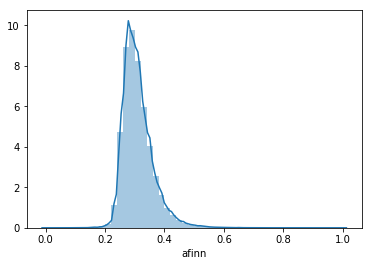

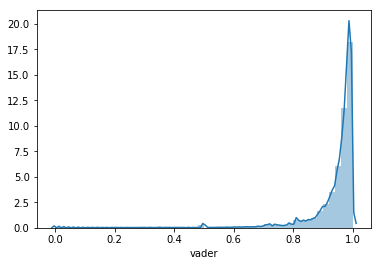

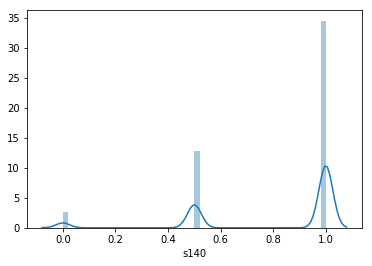

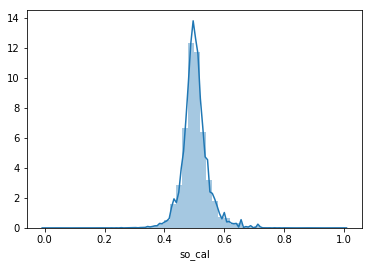

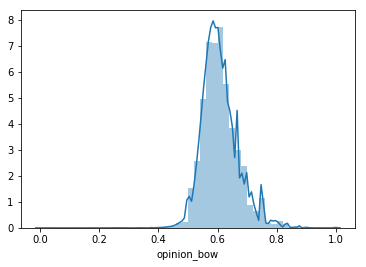

In [1725]:
plot_distributions(whole_score_table, main_tools)

## Afinn

In [1726]:
whole_score_table = utils.transform_tool(whole_score_table, 'afinn', 'log', 'outer')

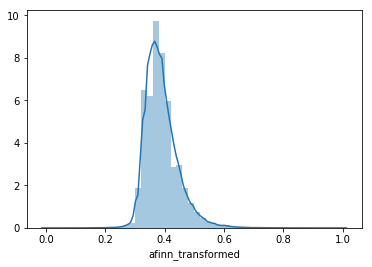

In [1727]:
sns.distplot(whole_score_table['afinn_transformed'])
plt.show()

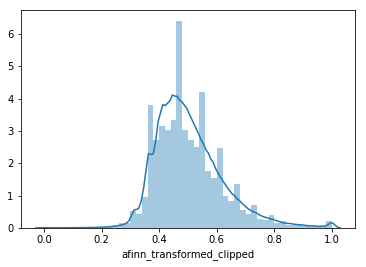

In [1728]:
sns.distplot(whole_score_table['afinn_transformed_clipped'])
plt.show()

## Vader

In [2170]:
whole_score_table = utils.transform_tool(whole_score_table, 'vader', 'exp', 'outer')

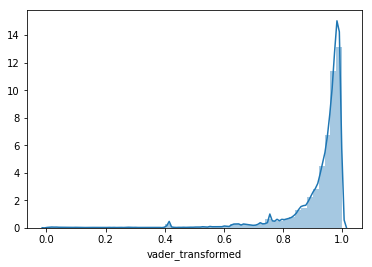

In [2171]:
sns.distplot(whole_score_table['vader_transformed'])
plt.show()

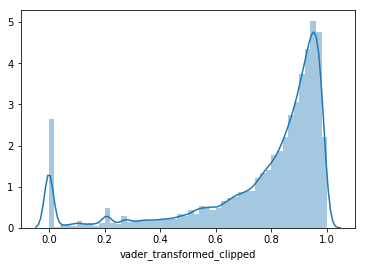

In [2172]:
sns.distplot(whole_score_table['vader_transformed_clipped'])
plt.show()

# S-140

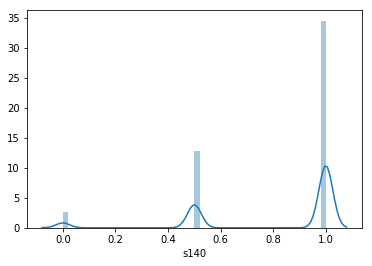

In [1732]:
sns.distplot(whole_score_table['s140'])
plt.show()

# So Cal

In [1733]:
whole_score_table = utils.transform_tool(whole_score_table, 'so_cal', 'log', 'outer')

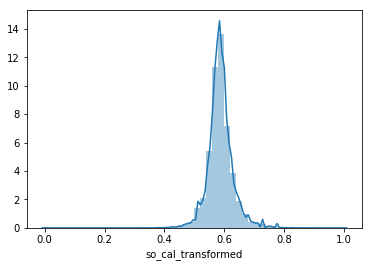

In [1734]:
sns.distplot(whole_score_table['so_cal_transformed'])
plt.show()

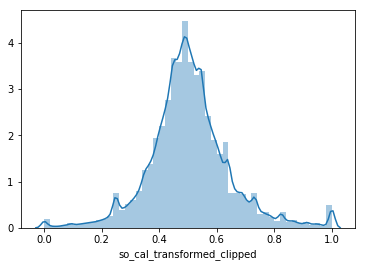

In [1735]:
sns.distplot(whole_score_table['so_cal_transformed_clipped'])
plt.show()

# Opinion_BOW

In [1736]:
whole_score_table = utils.transform_tool(whole_score_table, 'opinion_bow', 'log', 'outer')

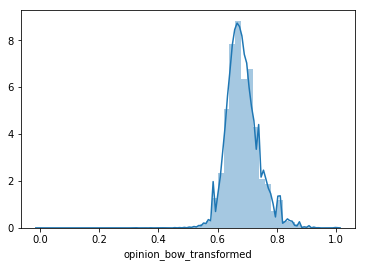

In [1737]:
sns.distplot(whole_score_table['opinion_bow_transformed'])
plt.show()

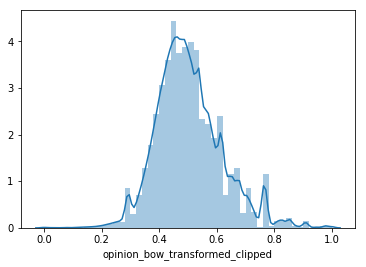

In [1738]:
sns.distplot(whole_score_table['opinion_bow_transformed_clipped'])
plt.show()

# Get Whole Averages +  convert into levels

## Score table

In [2173]:
voters_whole = ['afinn_transformed_clipped', 'vader_transformed_clipped', 's140', 'so_cal_transformed_clipped', 'opinion_bow_transformed_clipped']
whole_scores = whole_score_table[['id', 'comments']+voters_whole]
whole_scores.is_copy = False

## Score averages

In [2174]:
whole_scores['score_avg'] = np.average(whole_scores[voters_whole], axis=1)

In [2175]:
whole_scores = analysis.split_into_levels(whole_scores, whole_scores, 'score_avg')
whole_scores = analysis.split_into_levels(whole_scores, whole_scores, 'score_avg', type=2)

## Majority Vote

In [2176]:
whole_levels3_table =analysis.build_levels_table(whole_scores, voters_whole, type=2)

In [2177]:
voters_whole_level3 = [ "level3_"  + t for t in voters_whole] #'level_so_cal-norm',

In [2178]:
majority_vote_whole3 = majority_vote(whole_levels3_table, voters_whole_level3)

In [2179]:
voter_counts(whole_levels3_table, voters_whole_level3)

,level3_afinn_transformed_clipped,level3_opinion_bow_transformed_clipped,level3_s140,level3_so_cal_transformed_clipped,level3_vader_transformed_clipped,total
0,186682,174089,106905,176409,80818,225090


In [2180]:
whole_levels5_table =analysis.build_levels_table(whole_scores, voters_whole)

In [2181]:
voters_whole_level5 = [ "level5_"  + t for t in voters_whole] #'level_so_cal-norm',

In [2182]:
majority_vote_whole5 = majority_vote(whole_levels5_table, voters_whole_level5)

In [2183]:
voter_counts(whole_levels5_table, voters_whole_level5)

,level5_afinn_transformed_clipped,level5_opinion_bow_transformed_clipped,level5_s140,level5_so_cal_transformed_clipped,level5_vader_transformed_clipped,total
0,153000,163133,59559,168380,41530,225090


# Sentiment by Sentence

In [1761]:
main_sent_tools = ['afinn_sent', 'vader_sent', 's140_sent', 'so_cal_sent', 'opinion_bow_sent']

In [1762]:
sent_score_table = reviews[['id', 'comments']+main_sent_tools]

In [1768]:
def flatten_sent_scores(tbl, tools):
    new_tbl = pd.DataFrame()
    for t in tools:
        new_tbl[t] = [v for s in tbl[t] for v in eval(s)]
    return new_tbl

In [1769]:
all_sent_scores = flatten_sent_scores(sent_score_table, main_sent_tools)

In [1771]:
all_sent_scores.describe()

,afinn_sent,vader_sent,s140_sent,so_cal_sent,opinion_bow_sent
count,1.085703e+06,1.085703e+06,1.085703e+06,1.085703e+06,1.085703e+06
mean,2.472448e+00,4.359983e-01,2.174370e+00,2.136836e+00,2.145607e-01
std,2.576306e+00,3.473860e-01,7.853640e-01,2.522043e+00,2.253958e-01
min,-2.100000e+01,-9.897000e-01,0.000000e+00,-3.000000e+01,-1.000000e+00
25%,0.000000e+00,7.720000e-02,2.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,5.106000e-01,2.000000e+00,2.000000e+00,2.000000e-01
75%,4.000000e+00,6.908000e-01,2.000000e+00,3.500000e+00,3.333333e-01
max,4.100000e+01,9.963000e-01,4.000000e+00,5.760000e+01,1.000000e+00


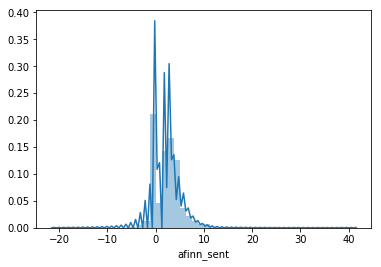

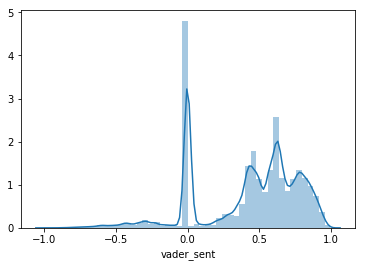

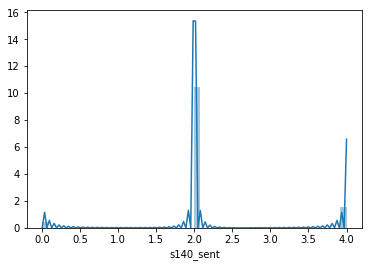

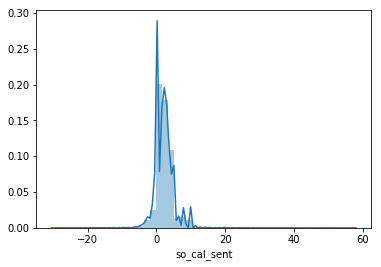

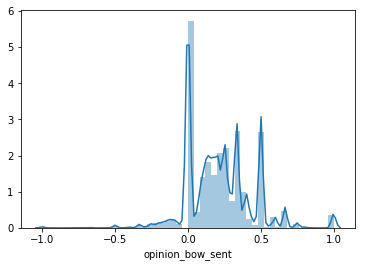

In [1772]:
plot_distributions(all_sent_scores, main_sent_tools)

In [1775]:
sent_score_table = normalise_tools_sent(sent_score_table, main_sent_tools)

## Afinn

In [1811]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'afinn_sent', 'log', 'inner')

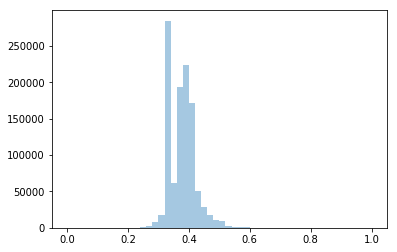

In [1833]:
a = np.array([float(j) for i in sent_score_table['afinn_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

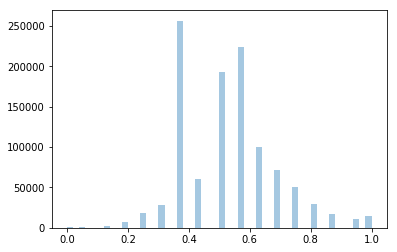

In [1834]:
a = np.array([float(j) for i in sent_score_table['afinn_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# Vader Sentence

In [1812]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'vader_sent', 'log', 'inner')

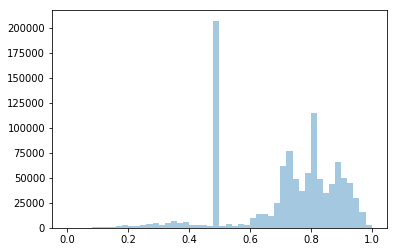

In [1814]:
a = np.array([float(j) for i in sent_score_table['vader_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

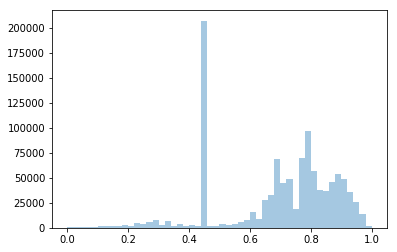

In [1815]:
a = np.array([float(j) for i in sent_score_table['vader_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# S140 Sentence

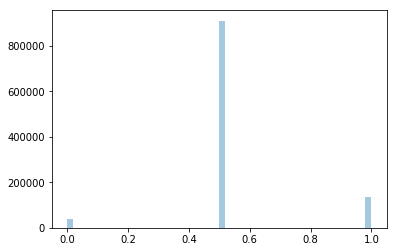

In [1816]:
a = np.array([float(j) for i in sent_score_table['s140_sent'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# SO_CAL Sentence

In [1830]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'so_cal_sent', 'log', 'outer')

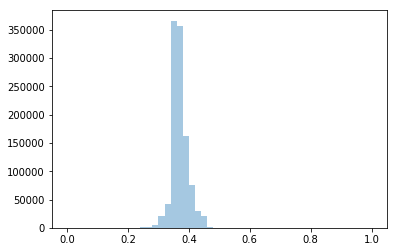

In [1831]:
a = np.array([float(j) for i in sent_score_table['so_cal_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

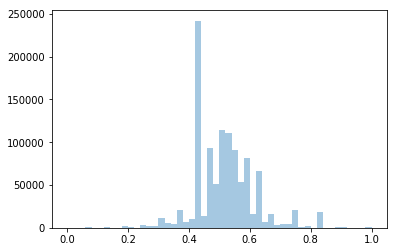

In [1832]:
a = np.array([float(j) for i in sent_score_table['so_cal_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

# Opinion-BOW Sentence

In [1823]:
sent_score_table = utils.transform_tool_sent(sent_score_table, 'opinion_bow_sent', 'log', 'inner')

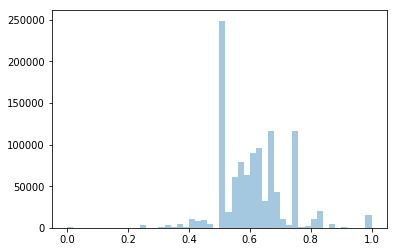

In [1824]:
a = np.array([float(j) for i in sent_score_table['opinion_bow_sent_transformed'] for j in i])
sns.distplot(a, kde=False)
plt.show()

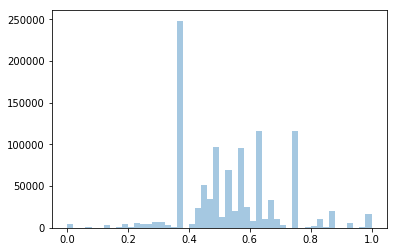

In [1825]:
a = np.array([float(j) for i in sent_score_table['opinion_bow_sent_transformed_clipped'] for j in i])
sns.distplot(a, kde=False)
plt.show()

## Reduce and Show Distribution

In [1877]:
voters_sent = ['afinn_sent_transformed_clipped', 'vader_sent_transformed', 's140_sent', 'so_cal_sent_transformed_clipped', 'opinion_bow_sent_transformed']

In [1878]:
sent_scores = sent_score_table[['id', 'comments']+voters_sent]

In [1879]:
sent_scores = sent.reduce_sentence_scores(sent_scores, voters_sent )

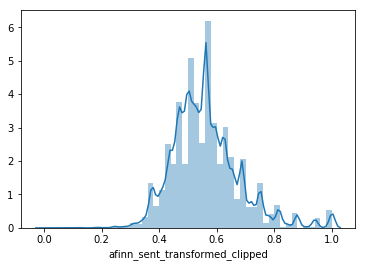

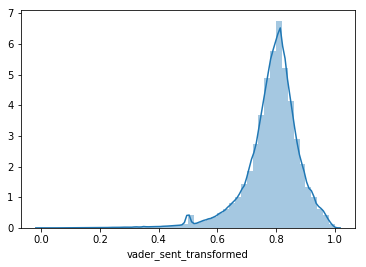

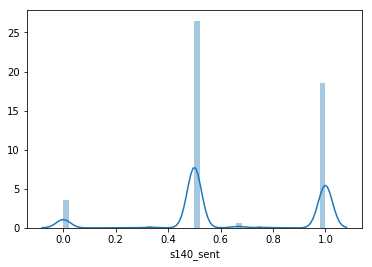

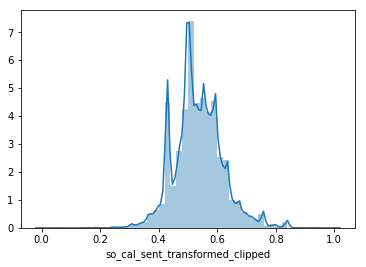

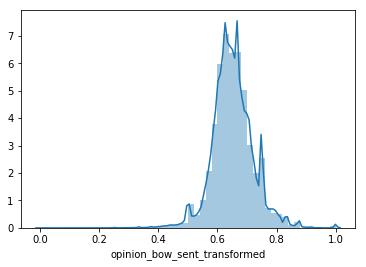

In [1880]:
plot_distributions(sent_scores, voters_sent)

# Get Sent averages +  convert into levels

## Score averages

In [2120]:
sent_scores['score_avg'] = np.average(sent_scores[voters_sent].astype(float), axis=1)

In [2121]:
sent_scores = analysis.split_into_levels(sent_scores, sent_scores, 'score_avg')
sent_scores = analysis.split_into_levels(sent_scores, sent_scores, 'score_avg', type=2)

## Majority Vote

In [2122]:
sent_levels3_table =analysis.build_levels_table(sent_scores, voters_sent, type=2)

In [2123]:
voters_sent_level3 = [ "level3_"  + t for t in voters_sent] #'level_so_cal-norm',

In [2124]:
majority_vote_sent3 = majority_vote(sent_levels3_table, voters_sent_level3)

In [2125]:
voter_counts(sent_levels3_table, voters_sent_level3)

,level3_afinn_sent_transformed_clipped,level3_opinion_bow_sent_transformed,level3_s140_sent,level3_so_cal_sent_transformed_clipped,level3_vader_sent_transformed,total
0,187621,156528,158939,166727,84220,225090


In [2126]:
sent_levels5_table =analysis.build_levels_table(sent_scores, voters_sent)

In [2127]:
voters_sent_level5 = [ "level5_"  + t for t in voters_sent] #'level_so_cal-norm',

In [2128]:
majority_vote_sent5 = majority_vote(sent_levels5_table, voters_sent_level5)

In [2129]:
voter_counts(sent_levels5_table, voters_sent_level5)

,level5_afinn_sent_transformed_clipped,level5_opinion_bow_sent_transformed,level5_s140_sent,level5_so_cal_sent_transformed_clipped,level5_vader_sent_transformed,total
0,180674,95616,113053,178531,36579,225090


## Combine all voters and get majority vote

In [2184]:
combined_voters3 = voters_sent_level3 + voters_whole_level3
combined_voters5 = voters_sent_level5 + voters_whole_level5

test_combined = sent_table_levels[['id', 'comments'] + voters_sent_level].join(whole_table_levels[['id'] + voters_whole_level].set_index('id'), on='id')

combined_voting = majority_vote(test_combined, combined_voters)

pd.options.display.max_colwidth = 500

# Average Tools

In [2131]:
afinn = sent_scores[['id', 'comments', 'afinn_sent_transformed_clipped']].join(whole_scores[['id', 'afinn_transformed_clipped']].set_index('id'), on='id')

In [2132]:
afinn['average_afinn'] = (sent_scores['afinn_sent_transformed_clipped'].astype(float) + whole_scores['afinn_transformed_clipped'].astype(float) )/2

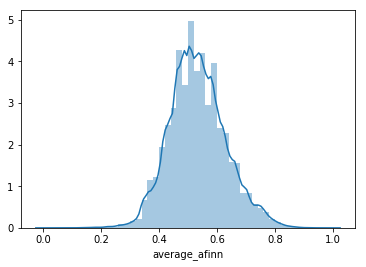

In [2133]:
sns.distplot(afinn['average_afinn'])
plt.show()

In [2186]:
vader = sent_scores[['id', 'comments', 'vader_sent_transformed']].join(whole_scores[['id', 'vader_transformed_clipped']].set_index('id'), on='id')

In [2187]:
vader['average_vader'] = (sent_scores['vader_sent_transformed'].astype(float) + whole_scores['vader_transformed_clipped'].astype(float) )/2

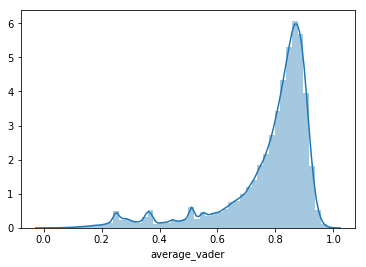

In [2188]:
sns.distplot(vader['average_vader'])
plt.show()

In [1906]:
s140 = sent_scores[['id', 'comments', 's140_sent']].join(whole_scores[['id', 's140']].set_index('id'), on='id')

In [1907]:
s140['average_s140'] = (sent_scores['s140_sent'].astype(float) + whole_scores['s140'].astype(float) )/2

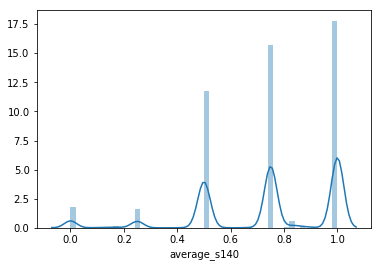

In [1908]:
sns.distplot(s140['average_s140'])
plt.show()

In [1909]:
so_cal = sent_scores[['id', 'comments', 'so_cal_sent_transformed_clipped']].join(whole_scores[['id', 'so_cal_transformed_clipped']].set_index('id'), on='id')

In [1910]:
so_cal['average_so_cal'] = (sent_scores['so_cal_sent_transformed_clipped'].astype(float) + whole_scores['so_cal_transformed_clipped'].astype(float) )/2

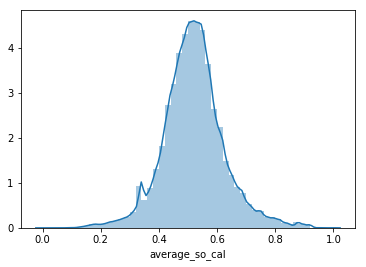

In [1911]:
sns.distplot(so_cal['average_so_cal'])
plt.show()

In [1914]:
opinion_bow = sent_scores[['id', 'comments', 'opinion_bow_sent_transformed']].join(whole_scores[['id', 'opinion_bow_transformed_clipped']].set_index('id'), on='id')

In [1915]:
opinion_bow['average_opinion_bow'] = (sent_scores['opinion_bow_sent_transformed'].astype(float) + whole_scores['opinion_bow_transformed_clipped'].astype(float) )/2

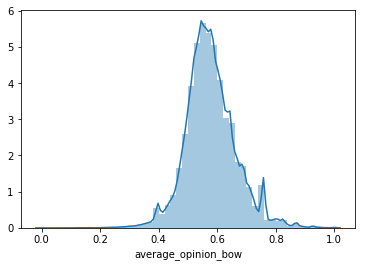

In [1916]:
sns.distplot(opinion_bow['average_opinion_bow'])
plt.show()

In [2137]:
avg_tools = [afinn, vader, s140, so_cal, opinion_bow]
voters_avg = ['average_afinn', 'average_vader', 'average_s140', 'average_so_cal', 'average_opinion_bow']
avg_table = join_multi_table(avg_tools, voters_avg)

### Level 3

In [2189]:
avg_table_levels3 =analysis.build_levels_table(avg_table, voters_avg, type=2)

In [2190]:
voters_avg_level3 = [ "level3_"  + t for t in voters_avg] 

In [2191]:
majority_vote_avg3 = majority_vote(avg_table_levels3, voters_avg_level3)

In [2192]:
voter_counts(avg_table_levels3, voters_avg_level3)

,level3_average_afinn,level3_average_opinion_bow,level3_average_s140,level3_average_so_cal,level3_average_vader,total
0,187643,181742,109199,176083,71247,225090


### Level 5

In [2193]:
avg_table_levels5 =analysis.build_levels_table(avg_table, voters_avg)

In [2194]:
voters_avg_level5 = [ "level5_"  + t for t in voters_avg] 

In [2195]:
majority_vote_avg5 = majority_vote(avg_table_levels5, voters_avg_level5)

In [2196]:
voter_counts(avg_table_levels5, voters_avg_level5)

,level5_average_afinn,level5_average_opinion_bow,level5_average_s140,level5_average_so_cal,level5_average_vader,total
0,168373,168510,73930,174756,23330,225090


# Interrator Tools 

In [2197]:
interrater_reviews = pd.read_csv('interrater/interrater_uq2.csv', index_col=0)

In [2198]:
voters3 = sent_levels3_table[['id', 'comments'] + voters_sent_level3].join(whole_levels3_table[['id'] + voters_whole_level3].set_index('id'), on='id')

In [2199]:
len(interrater_reviews)

70

In [2200]:
test_interrater3 = interrater_reviews[['id', 'interrater_weighted_avg']].join(voters3.set_index('id'), on='id')

In [2201]:
test_interrater3 = test_interrater3[~test_interrater3.comments.isnull()]

In [2202]:
test_interrater3['interrater_weighted_avg'] = utils.minmaxscale(test_interrater3['interrater_weighted_avg'])

In [2203]:
test_interrater3 = analysis.split_into_levels(test_interrater3, test_interrater3, 'interrater_weighted_avg', type=2)

In [2204]:
test_interrater3.level3_interrater_weighted_avg.value_counts()

3    30
1    14
2     8
Name: level3_interrater_weighted_avg, dtype: int64

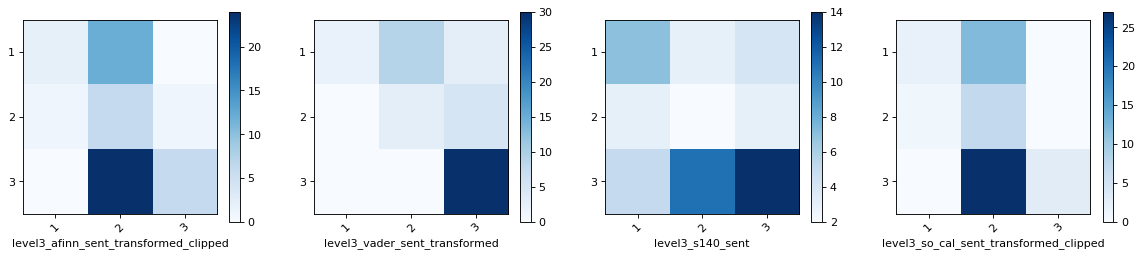

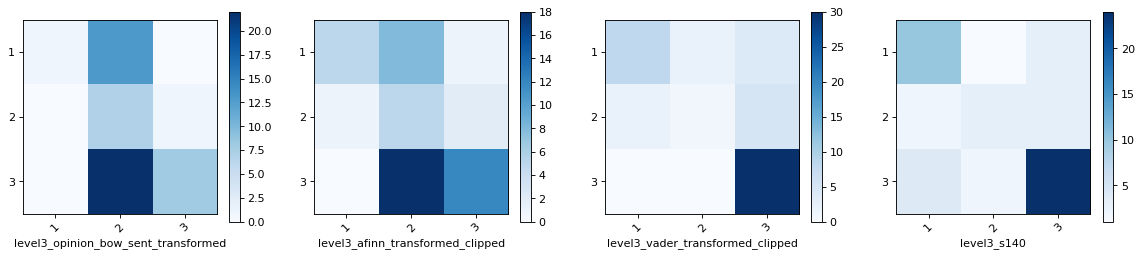

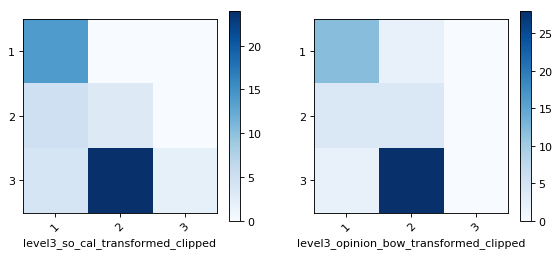

In [2205]:
analysis.plot_confusion_matrix_grid(test_interrater3, 'level3_interrater_weighted_avg', combined_voters3)

### Level 5

In [2206]:
voters5 = sent_levels5_table[['id', 'comments'] + voters_sent_level5].join(whole_levels5_table[['id'] + voters_whole_level5].set_index('id'), on='id')

In [2207]:
test_interrater5 = interrater_reviews[['id', 'interrater_weighted_avg']].join(voters5.set_index('id'), on='id')

In [2208]:
test_interrater5 = test_interrater5[~test_interrater5.comments.isnull()]

In [2209]:
test_interrater5['interrater_weighted_avg'] = utils.minmaxscale(test_interrater5['interrater_weighted_avg'])

In [2210]:
test_interrater5 = analysis.split_into_levels(test_interrater5, test_interrater5, 'interrater_weighted_avg')

In [2211]:
test_interrater5.level5_interrater_weighted_avg.value_counts()

5    23
4     9
1     8
3     6
2     6
Name: level5_interrater_weighted_avg, dtype: int64

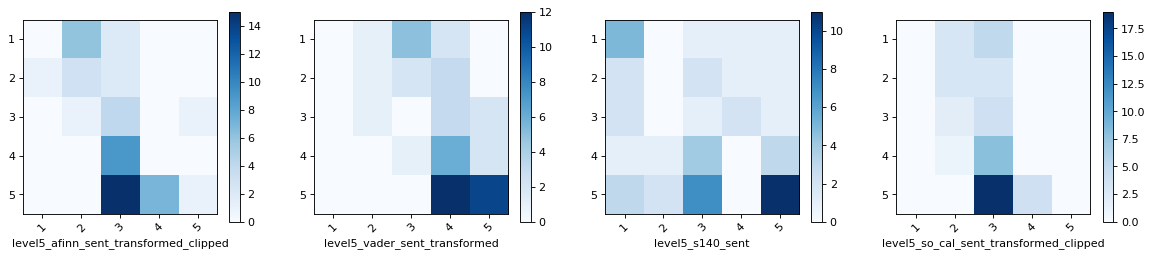

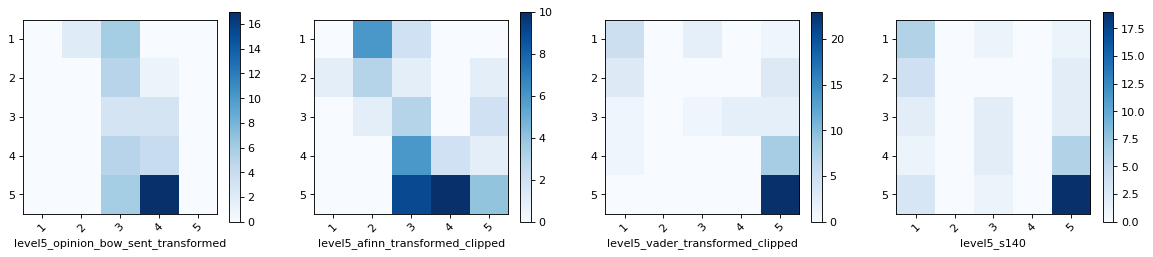

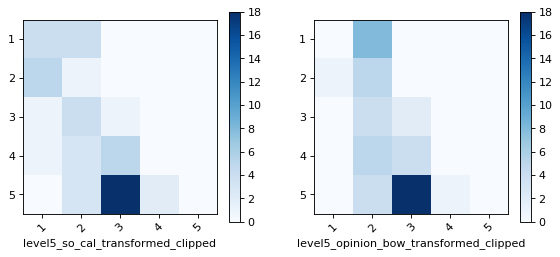

In [2212]:
analysis.plot_confusion_matrix_grid(test_interrater5, 'level5_interrater_weighted_avg', combined_voters5)

c = combined_voting[['id', 'vote']].rename(columns={'vote': 'combined_vote'})
w = whole_table_levels[['id', 'vote']].rename(columns={'vote': 'whole_vote'})
s = sent_table_levels[['id', 'vote']].rename(columns={'vote': 'sent_vote'})

majority_voters = c.join(w.set_index('id'), on='id').join(s.set_index('id'), on='id')

test_majority_vote = test_interrater[['id', 'level_interrater_weighted_avg']].join(majority_voters.set_index('id'), on='id')

analysis.plot_confusion_matrix_grid(test_majority_vote, 'level_interrater_weighted_avg', ['whole_vote', 'sent_vote', 'combined_vote'])

In [2213]:
test_avg_vote3 = test_interrater3[['id', 'level3_interrater_weighted_avg']].join(avg_table_levels3.set_index('id'), on='id')

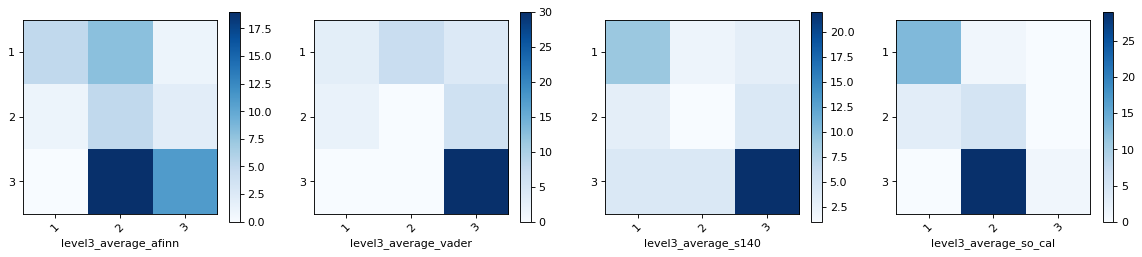

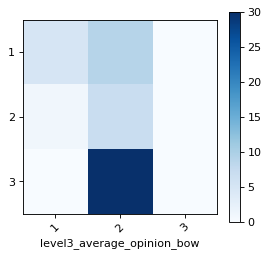

In [2214]:
analysis.plot_confusion_matrix_grid(test_avg_vote3 , 'level3_interrater_weighted_avg', voters_avg_level3)

In [2215]:
test_avg_vote5 = test_interrater5[['id', 'level5_interrater_weighted_avg']].join(avg_table_levels5.set_index('id'), on='id')

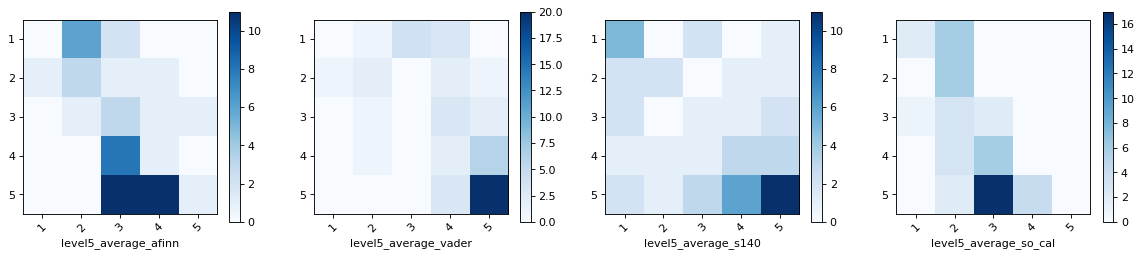

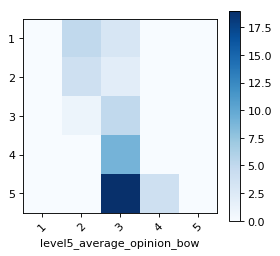

In [2216]:
analysis.plot_confusion_matrix_grid(test_avg_vote5 , 'level5_interrater_weighted_avg', voters_avg_level5)

In [2217]:
for a in voters_sent_level3:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater3, 'level3_interrater_weighted_avg', a)))
    
    

Error for level3_afinn_sent_transformed_clipped : 38.00
Error for level3_vader_sent_transformed : 26.00
Error for level3_s140_sent : 56.00
Error for level3_so_cal_sent_transformed_clipped : 40.00
Error for level3_opinion_bow_sent_transformed : 36.00


In [2218]:
for a in voters_sent_level5:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater5, 'level5_interrater_weighted_avg', a)))
    
    

Error for level5_afinn_sent_transformed_clipped : 98.00
Error for level5_vader_sent_transformed : 80.00
Error for level5_s140_sent : 174.00
Error for level5_so_cal_sent_transformed_clipped : 120.00
Error for level5_opinion_bow_sent_transformed : 84.00


In [2219]:
for a in voters_whole_level3:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater3, 'level3_interrater_weighted_avg', a)))
    
    

Error for level3_afinn_transformed_clipped : 33.00
Error for level3_vader_transformed_clipped : 25.00
Error for level3_s140 : 36.00
Error for level3_so_cal_transformed_clipped : 45.00
Error for level3_opinion_bow_transformed_clipped : 42.00


In [2220]:
for a in voters_whole_level5:
    print("Error for %s : %.2f" % (a, analysis.rss(test_interrater5, 'level5_interrater_weighted_avg', a)))
    
    

Error for level5_afinn_transformed_clipped : 87.00
Error for level5_vader_transformed_clipped : 85.00
Error for level5_s140 : 127.00
Error for level5_so_cal_transformed_clipped : 144.00
Error for level5_opinion_bow_transformed_clipped : 146.00


## Havent done majority yet 

In [1663]:
for a in majority_voters:
    print("Error for %s : %.2f" % (a, analysis.rss(test_majority_vote, 'level_interrater_weighted_avg', a)))
    

Error for id : 971934530155872896.00
Error for combined_vote : 74.00
Error for whole_vote : 118.00
Error for sent_vote : 84.00


In [1664]:
for a in voters_avg_level:
    print("Error for %s : %.2f" % (a, analysis.rss(test_avg_vote, 'level_interrater_weighted_avg', a)))
    

Error for level_average_afinn : 98.00
Error for level_average_vader : 74.00
Error for level_average_s140 : 132.00
Error for level_average_so_cal : 82.00
Error for level_average_opinion_bow : 102.00


In [1666]:
for a in ['level_avg']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_best_score_avg, 'level_interrater_weighted_avg', a)))
    

Error for level_avg : 60.00


In [1667]:
for a in ['vote']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_best_vote, 'level_interrater_weighted_avg', a)))
    

Error for vote : 78.00


In [1539]:
combined_voting.columns

Index(['id', 'comments', 'level_vader-sent_clipped_norm',
       'level_transformed_so_cal_sent', 'level_transformed_afinn',
       'level_transformed_vader', 'level_s140_norm',
       'level_transformed_so_cal', 'level_transformed_opinion_bow', 'vote'],
      dtype='object')

In [1568]:
best_tools = ['level_vader-sent_clipped_norm', 'level_transformed_so_cal_sent', 'level_transformed_afinn', 'level_s140_norm', 'level_transformed_opinion_bow']
best_table = combined_voting[['id', 'comments']+best_tools]

In [1569]:
 majority_vote_best = majority_vote(best_table, best_tools)

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [1570]:
test_best_vote = test_interrater[['id', 'level_interrater_weighted_avg']].join(majority_vote_best[['id', 'comments', 'vote']].set_index('id'), on='id')

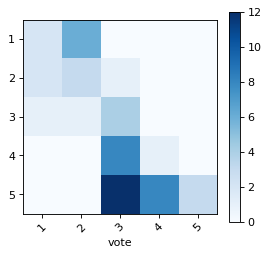

In [1571]:
analysis.plot_confusion_matrix_grid(test_best_vote , 'level_interrater_weighted_avg', ['vote'])

In [1644]:
best_tools_whole = ['transformed_afinn', 's140_norm', 'transformed_opinion_bow']
best_tools_sent = ['vader-sent_clipped_norm', 'transformed_so_cal_sent']
best_tools_score = best_tools_whole + best_tools_sent


In [1645]:
best_score_avg = whole_table[['id', 'comments']+best_tools_whole].join(sent_table[['id']+best_tools_sent].set_index('id'), on='id')

In [1646]:
best_score_avg['avg'] = np.average(best_score_avg[best_tools_score], axis=1)

In [1647]:
best_score_avg = analysis.build_levels_table(best_score_avg, ['avg'])

In [1649]:
test_best_score_avg = test_interrater[['id', 'level_interrater_weighted_avg']].join(best_score_avg.set_index('id'), on='id')

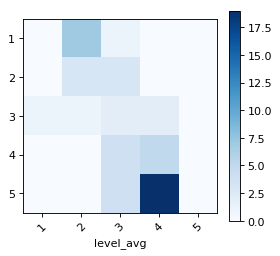

In [1650]:
analysis.plot_confusion_matrix_grid(test_best_score_avg , 'level_interrater_weighted_avg', ['level_avg'])

## Current Satisfaction Scores

In [1668]:
curr_sat = pd.read_csv('satisfaction_scores.csv', index_col=0)

In [1669]:
test_curr = test_interrater[['id', 'level_interrater_weighted_avg']].join(curr_sat[['id', 'satisfaction']].set_index('id'), on='id')

In [1674]:
test_curr = test_curr[~test_curr.satisfaction.isnull()]

In [1675]:
test_curr = analysis.split_into_levels(test_curr, test_curr,'satisfaction')

In [1677]:
for a in ['level_satisfaction']:
    print("Error for %s : %.2f" % (a, analysis.rss(test_curr, 'level_interrater_weighted_avg', a)))
    

Error for level_satisfaction : 53.00


# Extra + Normalisation

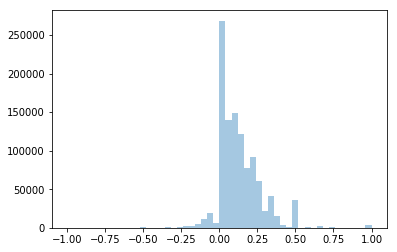

In [706]:
a = utils.flatten(reviews['opinion_freq-sent'])
sns.distplot(a, kde=False)
plt.show()

In [76]:
sent.print_anaysis(op_bow_sent_table, 264759774 , 'opinion_bow-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [83]:
normalization = reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id', 'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated',]]
normalization.is_copy = False

In [84]:
#Afinn
normalization[['afinn_norm_o', 'afinn_norm_clipo_o']] = afinn_table[afinn_chosen_o]
normalization[['afinn_norm_s', 'afinn_norm_clipi_s']] = afinn_sent_table[afinn_chosen_s]

In [85]:
# Vader
normalization[['vader_norm_o', 'vader_norm_clipo_o']] = vader_table[vader_chosen_o]
normalization[['vader_norm_s', 'vader_norm_clipi_s']] = vader_sent_table[vader_chosen_s]

In [86]:
# S140
normalization[['s140_norm_o']] = s140_table[s140_chosen_o]
normalization[['s140_norm_s']] = s140_sent_table[s140_chosen_s]

In [87]:
# Socal
normalization[['so_cal_norm_o', 'so_cal_norm_clipo_o']] = so_cal_table[so_cal_chosen_o]
normalization[['so_cal_norm_s', 'so_cal_norm_clipi_s']] = so_cal_sent_table[so_cal_chosen_s]

In [88]:
# Opinion Bow
normalization[['op_bow_norm_o', 'op_bow_norm_clipo_o']] = op_bow_table[op_bow_chosen_o]
normalization[['op_bow_norm_s', 'op_bow_norm_clipi_s']] = op_bow_sent_table[op_bow_chosen_s]

In [89]:
# Opinion Freq
normalization[['op_freq_norm_o', 'op_freq_norm_clipo_o']] = op_freq_table[op_freq_chosen_o]
normalization[['op_freq_norm_s', 'op_freq_norm_clipi_s']] = op_freq_sent_table[op_freq_chosen_s]

In [526]:
normalization.to_csv("score_backup.csv")

NameError: name 'normalization' is not defined

In [91]:
normalization.to_csv('reviews_normalisations.csv')

# Average by norm whole 2 versions

In [4]:
norm_reviews = pd.read_csv('reviews_normalisations.csv', index_col=0)

In [5]:
sent_norm_tools = ['afinn_norm_s', 'vader_norm_s', 's140_norm_s', 'so_cal_norm_s', 'op_bow_norm_s']
sent_adj_tools = ['afinn_norm_clipi_s', 'vader_norm_clipi_s', 'so_cal_norm_clipi_s', 'op_bow_norm_clipi_s']
whole_norm_tools = ['afinn_norm_o', 'vader_norm_o', 's140_norm_o', 'so_cal_norm_o','op_bow_norm_o']
whole_adj_tools = ['afinn_norm_clipo_o', 'vader_norm_clipo_o', 'so_cal_norm_clipo_o', 'op_bow_norm_clipo_o']
sent_tools = sent_norm_tools + sent_adj_tools
whole_tools = whole_norm_tools + whole_adj_tools

In [6]:
sentence_set = norm_reviews[['idReview', 'id', 'date', 'reviewer_id', 'listing_id', 'recipient_id',
       'comments', 'hostCancelled', 'token_len', 'num_of_sents',
       'google_langs', 'google_langs_conf', 'langdetect_langs',
       'langdetect_langs_conf', 'other_langs', 'translated']+ sent_tools]

In [69]:
sent.print_anaysis(so_cal_sent_table, 264759774 , 'so_cal-sentence-adj-1-norm', 1)

Orhun was a very friendly host. Even though he wasn't there the four days I visited the city, he responded very quickly and mailed me all the details necessary to get to the apartment in a very comprehensive and easy way. Probably the best host I have had so far on Airbnb. Everyone who is able/willing to pay that price for an Airbnb should definitely take a look at it. Location is very central, directly located in the party/pub area. as well. All in all, great stay!

In [7]:
whole_avgs_best = ['afinn_norm_clipo_o','vader_norm_clipo_o','s140_norm_o', 'so_cal_norm_clipo_o', 'op_bow_norm_o']
sent_avgs_best = ['afinn_norm_clipi_s','vader_norm_s','s140_norm_s', 'so_cal_norm_clipi_s', 'op_bow_norm_s']
best_of_each = ['afinn_norm_clipo_o','vader_norm_s','s140_norm_s', 'so_cal_norm_o', 'op_bow_norm_o']
match_1 = list(set(whole_avgs_best) - set(['s140_norm_o']))
match_2 = list(set(sent_avgs_best) - set(['s140_norm_s']))
match_3 = list(set(best_of_each) - set(['s140_norm_s']))
match_4 = ['vader_norm_clipo_o', 'vader_norm_s']
match_5 = ['afinn_norm_clipo_o', 'afinn_norm_clipi_s']
match_6 = match_4 + match_5
match_7 = match_6 + ['so_cal_norm_clipi_s']
match_8 = match_4 + ['afinn_norm_clipo_o']
match_9 = match_6 + ['s140_norm_s']
match_10 = match_6 + ['so_cal_norm_clipo_o']
match_11 = match_4 + ['so_cal_norm_clipo_o']
match_12 = ['vader_norm_clipo_o', 'afinn_norm_clipo_o']
match_13 = match_12 + ['so_cal_norm_clipo_o']

In [8]:
avg_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table = norm_reviews[['id','comments',  'token_len', 'num_of_sents', 'google_langs']]
avg_sent_table.is_copy = False
avg_table.is_copy = False

In [9]:
avg_table['avg_whole_norm'] = np.sum(norm_reviews[whole_norm_tools], axis=1)/5
avg_table['avg_whole_adj'] = np.sum(norm_reviews[whole_adj_tools], axis=1)/4
avg_table['avg_whole_best'] = np.sum(norm_reviews[whole_avgs_best], axis=1)/5
avg_table['avg_best_of_each'] = np.sum(norm_reviews[best_of_each], axis=1)/5

In [12]:
sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))] = sentence_set[list((set(sent_norm_tools)).union(set(sent_adj_tools)))].applymap(lambda x : utils.str_to_list(x))

/Users/lynraybarends/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2352: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [14]:
sentence_set[sent_norm_tools].head()

,afinn_norm_s,vader_norm_s,s140_norm_s,so_cal_norm_s,op_bow_norm_s
201,[0.403],[0.929],[0.5],[0.374],[0.75]
202,"[0.387, 0.355, 0.323, 0.323, 0.387]","[0.813, 0.498, 0.472, 0.421, 0.83]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.388, 0.397, 0.37, 0.325, 0.434]","[0.667, 0.667, 0.556, 0.5, 0.667]"
203,"[0.403, 0.387, 0.371, 0.387, 0.371]","[0.851, 0.885, 0.738, 0.83, 0.68]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.365, 0.394, 0.37, 0.434, 0.342]","[0.643, 0.55, 0.75, 0.75, 0.6]"
204,"[0.403, 0.452, 0.371, 0.435, 0.387, 0.403, 0.3...","[0.919, 0.91, 0.836, 0.885, 0.813, 0.777, 0.83...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","[0.369, 0.4, 0.365, 0.376, 0.388, 0.377, 0.434...","[0.556, 0.714, 0.667, 0.875, 0.667, 0.625, 0.7..."
205,"[0.484, 0.387, 0.323, 0.371]","[0.942, 0.813, 0.485, 0.71]","[1.0, 0.5, 0.5, 0.5]","[0.388, 0.388, 0.34, 0.342]","[0.7, 0.75, 0.5, 0.571]"


In [18]:
avg_sent_table['sent_avgs_norm'] = sentence_set[sent_norm_tools].sum(axis=1)/len(sent_norm_tools)
avg_sent_table['sent_avgs_adj'] = sentence_set[sent_adj_tools].sum(axis=1)/len(sent_adj_tools)
avg_sent_table['sent_avgs_best'] = sentence_set[sent_avgs_best].sum(axis=1)/len(sent_avgs_best)

In [21]:
avg_table['avg_sent_norm'] = sent.reduce_to_average(avg_sent_table['sent_avgs_norm'])
avg_table['avg_sent_adj'] = sent.reduce_to_average(avg_sent_table['sent_avgs_adj'])
avg_table['avg_sent_best'] = sent.reduce_to_average(avg_sent_table['sent_avgs_best'])

In [45]:
norm_reviews = sent.reduce_sentence_scores(norm_reviews, sent_tools, True)

In [50]:
norm_reviews[sent_tools] = norm_reviews[sent_tools].astype(float)

In [51]:
avg_table['avg_match_1'] = np.array(np.sum(norm_reviews[match_1], axis=1))/len(match_1)
avg_table['avg_match_2'] = np.array(np.sum(norm_reviews[match_2], axis=1))/len(match_2)
avg_table['avg_match_3'] = np.array(np.sum(norm_reviews[match_3], axis=1))/len(match_3)
avg_table['avg_match_4'] = np.array(np.sum(norm_reviews[match_4], axis=1))/len(match_4)
avg_table['avg_match_5'] = np.array(np.sum(norm_reviews[match_5], axis=1))/len(match_5)
avg_table['avg_match_6'] = np.array(np.sum(norm_reviews[match_6], axis=1))/len(match_6)
avg_table['avg_match_7'] = np.array(np.sum(norm_reviews[match_7], axis=1))/len(match_7)
avg_table['avg_match_8'] = np.array(np.sum(norm_reviews[match_8], axis=1))/len(match_8)
avg_table['avg_match_9'] = np.array(np.sum(norm_reviews[match_9], axis=1))/len(match_9)
avg_table['avg_match_10'] = np.array(np.sum(norm_reviews[match_10], axis=1))/len(match_10)
avg_table['avg_match_11'] = np.array(np.sum(norm_reviews[match_11], axis=1))/len(match_11)
avg_table['avg_match_12'] = np.array(np.sum(norm_reviews[match_12], axis=1))/len(match_12)
avg_table['avg_match_13'] = np.array(np.sum(norm_reviews[match_13], axis=1))/len(match_13)

In [53]:
avg_tools = ['avg_match_1','avg_match_2','avg_match_3','avg_match_4','avg_match_5','avg_match_6','avg_match_7',
             'avg_match_8','avg_match_9','avg_match_10','avg_match_11','avg_match_12','avg_match_13','avg_sent_norm','avg_sent_adj','avg_sent_best','avg_whole_norm','avg_whole_adj','avg_whole_best', 'avg_best_of_each']


In [54]:
avg_table[avg_tools] = avg_table[avg_tools].astype(float)

In [109]:
avg_table[(avg_table['avg_whole_norm'] <0.3)]

,id,comments,token_len,num_of_sents,google_langs,avg_whole_norm,avg_whole_adj,avg_whole_best,avg_best_of_each,avg_sent_norm,avg_sent_adj,avg_sent_best,avg_match_1,avg_match_2,avg_match_3,avg_match_4,avg_match_5,avg_match_6,avg_match_7,avg_match_8,avg_match_9,avg_match_10,avg_match_11,avg_match_12,avg_match_13
232,6236,Dead cockroaches. Cat hair everywhere. Not ver...,8,3,en,0.260298,0.146986,0.176168,0.258454,0.412,0.325,0.396,0.220211,0.36950,0.405567,0.1650,0.324940,0.244970,0.238176,0.208627,0.295976,0.195976,0.110000,0.147940,0.098627
375,29344,The apartment is not the place shown in the pi...,39,3,en,0.273896,0.172489,0.196571,0.275544,0.346,0.298,0.341,0.245713,0.34325,0.428930,0.1690,0.362791,0.265896,0.258717,0.222528,0.279317,0.226378,0.135436,0.164791,0.132630
384,69674,We stayed at Shun's place for a week in july. ...,97,8,en,0.276642,0.174527,0.200677,0.277534,0.418,0.381,0.426,0.250846,0.42275,0.466918,0.2400,0.368650,0.304325,0.308060,0.275433,0.331060,0.260079,0.187698,0.173150,0.143131
481,2295972,We've already stayed five times with airbnb an...,82,5,en,0.225142,0.074890,0.134379,0.207693,0.365,0.227,0.326,0.167974,0.28225,0.338867,0.1585,0.210160,0.184330,0.173264,0.158107,0.247464,0.147464,0.105667,0.078660,0.052440
538,12649702,My first experience with Airbnb in this apartm...,330,15,en,0.241306,0.086892,0.135601,0.221120,0.374,0.341,0.362,0.169501,0.38525,0.395400,0.2380,0.214370,0.226185,0.233948,0.193247,0.234348,0.185461,0.166188,0.051870,0.042102
561,20676723,This place is horrible and not what is represe...,22,3,en,0.196904,0.043745,0.123110,0.183846,0.243,0.109,0.179,0.153888,0.18175,0.286307,0.1130,0.191990,0.152495,0.121996,0.133660,0.155396,0.121996,0.075333,0.087490,0.058326
587,31027432,He is very quiet but gave no idea about the ar...,42,3,en,0.271267,0.153246,0.181176,0.266341,0.347,0.332,0.332,0.226470,0.37275,0.432176,0.1985,0.324940,0.261720,0.252976,0.230960,0.242776,0.214384,0.140680,0.147940,0.106973
606,41269884,Our apartment building in Philadelphia caught ...,159,6,en,0.257577,0.138452,0.173960,0.244059,0.364,0.329,0.360,0.217450,0.36675,0.410324,0.2105,0.238490,0.224495,0.245796,0.198660,0.246196,0.205660,0.183774,0.087490,0.101767
1780,2838353,"SHOCKING describes best the place, beginning w...",256,16,en,0.285734,0.205235,0.220537,0.290915,0.420,0.395,0.429,0.275672,0.43525,0.491894,0.2565,0.385234,0.320867,0.323294,0.297489,0.337894,0.282369,0.213792,0.189734,0.169281
2143,108810133,DO NOT GO HERE! I wouldn't recommend this plac...,239,20,en,0.240116,0.112347,0.148457,0.225740,0.373,0.310,0.360,0.185571,0.35550,0.374425,0.1845,0.252160,0.218330,0.219264,0.175440,0.249664,0.174664,0.123000,0.078660,0.052440


In [212]:
avg_table.to_csv('sent_avgs.csv')

In [213]:
len(avg_table)

225448

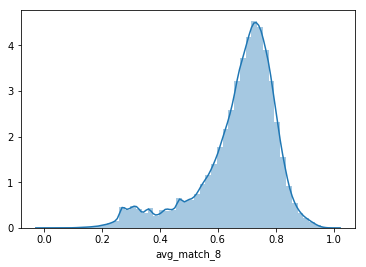

In [104]:
sns.distplot(avg_table['avg_match_8'])
plt.show()

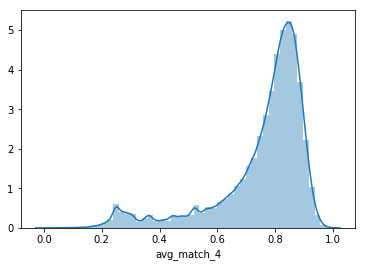

In [216]:
sns.distplot(avg_table['avg_match_4'])
plt.show()

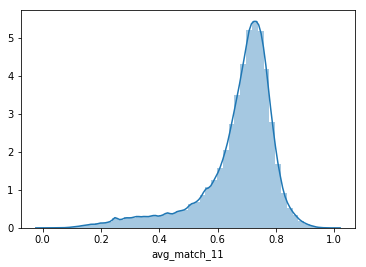

In [106]:
sns.distplot(avg_table['avg_match_11'])
plt.show()

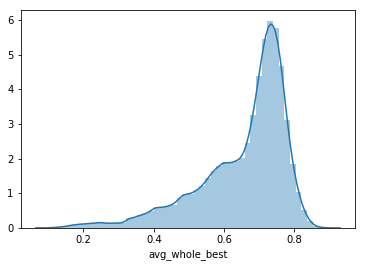

In [111]:
sns.distplot(avg_table['avg_whole_best'])
plt.show()

In [158]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
stopWords = set(stopwords.words('english'))

In [208]:
bad_reviews = vader_table[(vader_table['vader-norm'] <0.2)]

In [209]:
r, vc, v, idf = lang.pipeline(bad_reviews['comments'], stopWords)

In [210]:
vocab_table = lang.create_vocab_count_table(vc)

In [211]:
vocab_table.sort_values(by='counts', ascending=False).head(40)

,counts,word
6,1732,apartment
7,928,place
100,833,us
85,723,host
21,713,stay
55,681,room
173,672,one
104,619,would
16,555,airbnb
54,527,night


# Comparison 

In [102]:
utils.get_comments(norm_reviews, 'id', 106703, 'comments')

"Is glad to stay in Tina's Apt. the apt is just closed to the convinent store (around the corner), food (1 block away) and take another 7 to 10 blocks to times square.."

# Opinion-Freq Sentence

In [742]:
op_freq_sent_table = utils.transform_score_sent(reviews, 'opinion_freq-sent')

In [743]:
op_freq_sent_table.head()

,id,comments,token_len,num_of_sents,opinion_freq-sent,opinion_freq-sent-ndist,opinion_freq-sent-norm,opinion_freq-sent-ndist-norm
202,248421191,Robin’s place was great. Very spacious and we ...,55,5,"[0.2, 0.1111111111111111, 0.04, 0.0, 0.1666666...","[0.7884573603642703, 0.7472144018302211, 0.712...","[0.600, 0.556, 0.520, 0.500, 0.583]","[0.718, 0.680, 0.649, 0.631, 0.704]"
203,22938,Good location - easy access to Times Square an...,40,5,"[0.2, 0.058823529411764705, 0.25, 0.5, 0.14285...","[0.7884573603642703, 0.7221347174331975, 0.810...","[0.600, 0.529, 0.625, 0.750, 0.571]","[0.718, 0.657, 0.738, 0.834, 0.694]"
204,234213,We had the best possible time in NYC and Russe...,88,8,"[0.058823529411764705, 0.21428571428571427, 0....","[0.7221347174331975, 0.7949298748698876, 0.762...","[0.529, 0.607, 0.571, 0.650, 0.571, 0.571, 0.6...","[0.657, 0.724, 0.694, 0.758, 0.694, 0.694, 0.7..."
205,264416,Three of us stayed at this place for a week- i...,43,4,"[0.23529411764705882, 0.3333333333333333, 0.0,...","[0.8043728156701697, 0.8472978603872034, 0.693...","[0.618, 0.667, 0.500, 0.538]","[0.732, 0.771, 0.631, 0.665]"
206,843520,A great apartment in the perfect location. I w...,20,2,"[0.2857142857142857, 0.0]","[0.8266785731844679, 0.6931471805599453]","[0.643, 0.500]","[0.752, 0.631]"


In [744]:
opinion_freq_reduce = op_freq_sent_table[['id', 'comments', 'opinion_freq-sent-norm', 'opinion_freq-sent-ndist-norm']]

In [745]:
opinion_freq_reduce = sent.reduce_sentence_scores(opinion_freq_reduce,['opinion_freq-sent-norm', 'opinion_freq-sent-ndist-norm'] )

In [746]:
opinion_freq_reduce = analysis.split_into_levels(opinion_freq_reduce, opinion_freq_reduce, 'opinion_freq-sent-ndist-norm')

In [747]:
opinion_freq_reduce['level_opinion_freq-sent-ndist-norm'].value_counts()

4    221009
5      3688
3       386
2         7
Name: level_opinion_freq-sent-ndist-norm, dtype: int64

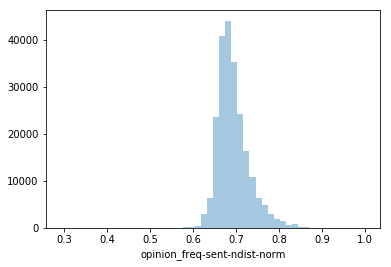

In [748]:
sns.distplot(opinion_freq_reduce['opinion_freq-sent-ndist-norm'].astype(float), kde=False)
plt.show()

In [721]:
op_freq_chosen_s = ['opinion_freq-sentence-norm', 'opinion_freq-sentence-adj-2-norm']